In [43]:
#Importing libraries
import numpy as np
import pandas as pd

#Reading the data source file
data = pd.read_csv('https://raw.githubusercontent.com/Redback-Operations/redback-fit-sports-performance/main/Cycling%20Analysis/data/extended_activities_TRI001.csv')

# Convert 'Activity Date' column to datetime
data['Activity Date'] = pd.to_datetime(data['Activity Date'])

#Filtering'Cycling' sessions from dataset
data = data[data['Activity Type'] == 'Ride']

In [44]:
#Plotting results
import matplotlib.pyplot as plt

def plot_results(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual FTP')
    plt.ylabel('Predicted FTP')
    plt.title('Actual vs Predicted FTP: {}'.format(model_name))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal refernce line
    plt.show()

In [45]:
# Removing unnecesary columns
def reduce_columns(data):

    # Removing columns that are not related to FTP
    data = data.drop(['Activity ID',
                    'Activity Name',
                    'Activity Type',
                    'Commute',
                    'Activity Gear',
                    'Filename',
                    'Dirt Distance',
                    'Total Steps'
                    ],
                    axis=1)

    return data

**The FTP is distributed across the dataset based on the five days provided. Models are trained using a power curve from a single day.**

In [46]:
# Adding FTP data to the dataframe
ftp_data = pd.DataFrame({
            'Date': ['2017-06-28', '2020-09-18', '2021-01-31', '2022-09-23', '2023-01-05'],
            'FTP': [222*0.95, 238*0.95, 245*0.95, 262*0.95, 266*0.95]
        })
data = reduce_columns(data)
# Converting date columns to datetime format
data['Activity Date'] = pd.to_datetime(data['Activity Date'])
ftp_data['Date'] = pd.to_datetime(ftp_data['Date'])

In [47]:
ftp_data

,Date,FTP
0,2017-06-28,210.90
1,2020-09-18,226.10
2,2021-01-31,232.75
3,2022-09-23,248.90
4,2023-01-05,252.70


In [48]:
# Scaling FTP test scores

# DataFrame with a continuous date range
date_range = pd.date_range(start=ftp_data['Date'].min(), end=ftp_data['Date'].max())
all_dates = pd.DataFrame({'Date': date_range})

# Merging the FTP test data with the date range DataFrame
all_dates_with_ftp = pd.merge(all_dates, ftp_data, on='Date', how='left')

# Linearly interpolating the missing FTP values
all_dates_with_ftp['FTP'] = all_dates_with_ftp['FTP'].interpolate(method='linear')

# Merging the interpolated FTP data with the original workout data
ftp_values = pd.merge_asof(data.sort_values('Activity Date'), all_dates_with_ftp, left_on='Activity Date', right_on='Date', direction='backward')

# Dropping the extra 'Date' column
ftp_values = ftp_values.drop(columns=['Date'])

In [49]:
#Listing the columns from the dataset after merging
ftp_values.columns

Index(['Activity Date', 'Elapsed Time', 'Max Heart Rate', 'Relative Effort',
       'Athlete Weight', 'Bike Weight', 'Moving Time', 'Distance', 'Max Speed',
       'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low',
       'Elevation High', 'Max Grade', 'Average Grade', 'Max Cadence',
       'Average Cadence', 'Average Heart Rate', 'Average Watts', 'Calories',
       'Average Temperature', 'Total Work', 'Perceived Exertion',
       'Weighted Average Power', 'Power Count', 'Prefer Perceived Exertion',
       'Perceived Relative Effort', 'From Upload', 'Grade Adjusted Distance',
       'Bike', 'Gear', 'Flagged', 'Average Elapsed Speed', 'Maximum Pace 5s',
       'Maximum Pace 10s', 'Maximum Pace 30s', 'Maximum Pace 1.0min',
       'Maximum Pace 5.0min', 'Maximum Pace 10.0min', 'Maximum Pace 20.0min',
       'Maximum Pace 30.0min', 'Maximum Pace 1.0 hr', 'Maximum Pace 1.5 hr',
       'Maximum Pace 2.0 hr', 'Maximum Power 5s', 'Maximum Power 10s',
       'Maximum Power 30

In [50]:
#Choosing power curve as the input to the model
input_cols = ['Maximum Power 5s', 'Maximum Power 10s',
       'Maximum Power 30s', 'Maximum Power 1.0min', 'Maximum Power 5.0min',
       'Maximum Power 10.0min', 'Maximum Power 20.0min',
       'Maximum Power 30.0min', 'Maximum Power 1.0 hr', 'Maximum Power 1.5 hr',
       'Maximum Power 2.0 hr']
ftp_values[input_cols]  # Listing the features

,Maximum Power 5s,Maximum Power 10s,Maximum Power 30s,Maximum Power 1.0min,Maximum Power 5.0min,Maximum Power 10.0min,Maximum Power 20.0min,Maximum Power 30.0min,Maximum Power 1.0 hr,Maximum Power 1.5 hr,Maximum Power 2.0 hr
0,439.2,412.9,342.1,221.2,162.2,136.3,120.8,109.8,105.4,0.0,0.0
1,386.2,342.1,236.1,184.3,150.6,131.4,122.1,120.3,115.6,0.0,0.0
2,422.6,390.5,265.1,213.3,146.2,135.1,127.5,125.5,110.2,104.7,0.0
3,473.0,452.0,303.1,262.0,161.9,146.7,139.7,134.0,112.3,0.0,0.0
4,404.0,342.9,243.9,208.3,134.7,124.0,119.4,115.5,99.8,96.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...
176,392.2,358.3,293.4,271.2,246.5,242.5,236.1,229.8,118.3,0.0,0.0
177,329.6,306.4,291.5,260.2,215.3,201.9,188.0,176.2,0.0,0.0,0.0
178,536.8,417.6,269.0,236.5,211.2,200.0,185.6,181.7,169.4,167.0,166.9
179,278.4,252.3,211.8,194.2,174.5,170.5,166.6,164.7,159.8,156.5,151.2


Mean Squared Error: 105.21499973361735
R² Score: 0.3962803343346377


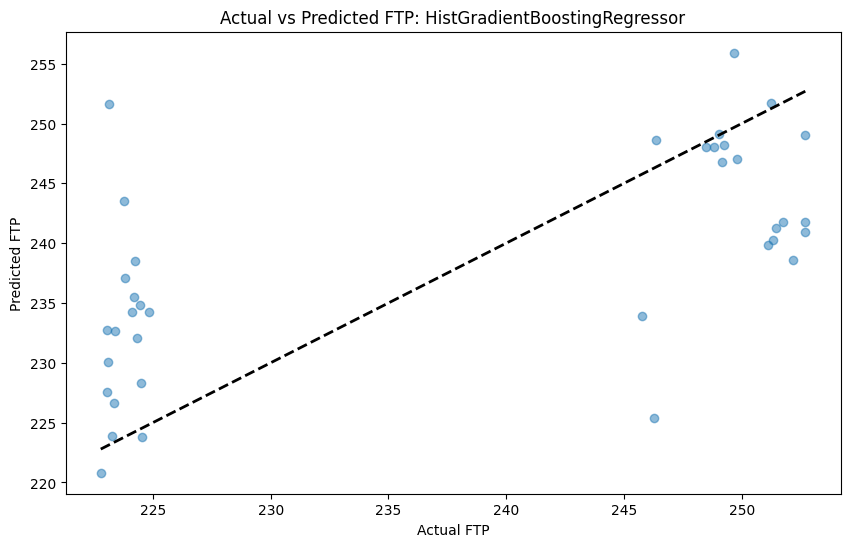

In [51]:
#HistGradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Dropping any rows where FTP is NaN
data = ftp_values.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

X = data[input_cols]  # Features
y = data['FTP']       # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a HistGradientBoostingRegressor model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Predicting on the testing set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Plotting the results
plot_results(y_test, y_pred, 'HistGradientBoostingRegressor')


**HistGradientBoostingRegressor model:**

*MSE: 105.21*  
*R²: 0.396*  
*Shows Moderate fit, and there is potential for improvement.*

Mean Squared Error: 179.35885328399377
R² Score: -0.029154276603947427


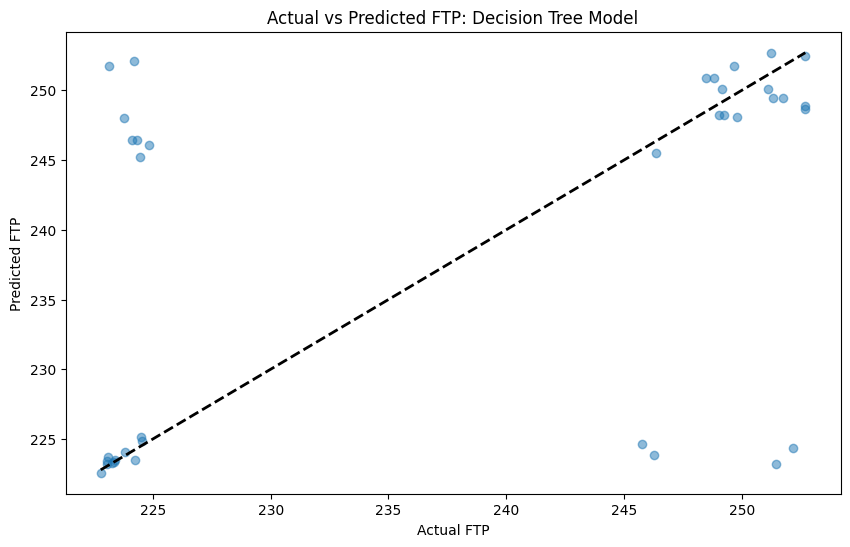

In [53]:
#Decision Tree Model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Random Forest model
from sklearn.model_selection import train_test_split

data = ftp_values

# Dropping any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

X = data[input_cols]  # Features
y = data['FTP']       # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Decision Tree model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Predicting on the testing set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

plot_results(y_test, y_pred, 'Decision Tree Model')

**Decision Tree model:**

*MSE: 179.35*  
*R²: -0.029*  
*Poor performance compared to HistGradientBoosterRegressor*

Mean Squared Error: 99.05097501322187
R² Score: 0.4316492736757189


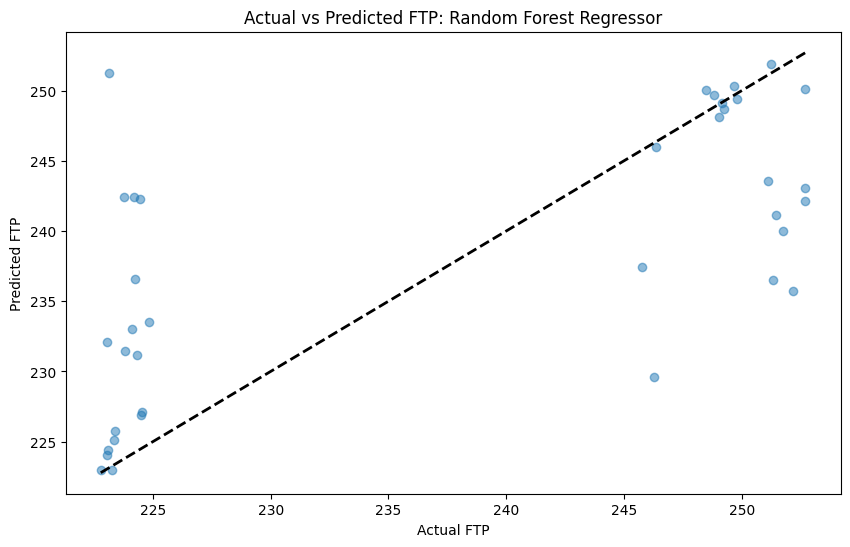

In [55]:
# Random Forest model

from sklearn.ensemble import RandomForestRegressor

data = ftp_values

# Dropping any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

X = data[input_cols]  # Features
y = data['FTP']       # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Creating a Linear Regression model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predicting on the testing set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

plot_results(y_test, y_pred, 'Random Forest Regressor')

**Random Forest model:**

*MSE: 99.05*  
*R²: 0.43*  
*Better performance compared to the previous 2 models*

**Random forest model has displayed the best performance among the three considered**

**Now, let us try training the model based on 45 day maximum power instead of 1 day power curve.**

In [56]:
import pandas as pd

# Reading the DataFrame
file_path = 'https://raw.githubusercontent.com/Redback-Operations/redback-fit-sports-performance/main/Cycling%20Analysis/data/extended_activities_TRI001.csv'
data = pd.read_csv(file_path)

# Filtering for 'Ride' activities
data = data[data['Activity Type'] == 'Ride']

# Removing columns that are not related to FTP
data = data.drop(['Activity ID',
                  'Activity Name',
                  'Activity Type',
                  'Commute',
                  'Activity Gear',
                  'Filename',
                  'Dirt Distance',
                  'Total Steps'
                  ],
                  axis=1)

# Converting 'Activity Date' to datetime and set as index
data['Activity Date'] = pd.to_datetime(data['Activity Date'])
data.set_index('Activity Date', inplace=True)

# Sorting the dataframes by date
data.sort_index(inplace=True)

data_original = data.copy()

# Identifying 'Maximum Power xx' fields and calculate 45-day rolling maximum
for column in data.columns:
    if column.startswith('Maximum Power'):
        # Calculating 45-day rolling max
        rolling_max = data[column].rolling(window='45D', min_periods=1).max()

        # Replacing original column or create a new one
        new_column_name = '45 Day ' + column
        data[new_column_name] = rolling_max

# Reset index if needed
data.reset_index(inplace=True)

data.drop(columns=[col for col in data.columns if col.startswith('Maximum Power')], inplace=True)

In [57]:
# Scaling FTP test scores

# DataFrame with a continuous date range
date_range = pd.date_range(start=ftp_data['Date'].min(), end=ftp_data['Date'].max())
all_dates = pd.DataFrame({'Date': date_range})

# Merging the FTP test data with the date range DataFrame
all_dates_with_ftp = pd.merge(all_dates, ftp_data, on='Date', how='left')

# Interpolating the missing FTP values
all_dates_with_ftp['FTP'] = all_dates_with_ftp['FTP'].interpolate(method='linear')

# Merging the interpolated FTP data with the original workout data
ftp_values = pd.merge_asof(data.sort_values('Activity Date'), all_dates_with_ftp, left_on='Activity Date', right_on='Date', direction='backward')

# Dropping the extra date column
ftp_values = ftp_values.drop(columns=['Date'])

In [58]:
#Listing the columns from dataset after merging
ftp_values.columns

Index(['Activity Date', 'Elapsed Time', 'Max Heart Rate', 'Relative Effort',
       'Athlete Weight', 'Bike Weight', 'Moving Time', 'Distance', 'Max Speed',
       'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low',
       'Elevation High', 'Max Grade', 'Average Grade', 'Max Cadence',
       'Average Cadence', 'Average Heart Rate', 'Average Watts', 'Calories',
       'Average Temperature', 'Total Work', 'Perceived Exertion',
       'Weighted Average Power', 'Power Count', 'Prefer Perceived Exertion',
       'Perceived Relative Effort', 'From Upload', 'Grade Adjusted Distance',
       'Bike', 'Gear', 'Flagged', 'Average Elapsed Speed', 'Maximum Pace 5s',
       'Maximum Pace 10s', 'Maximum Pace 30s', 'Maximum Pace 1.0min',
       'Maximum Pace 5.0min', 'Maximum Pace 10.0min', 'Maximum Pace 20.0min',
       'Maximum Pace 30.0min', 'Maximum Pace 1.0 hr', 'Maximum Pace 1.5 hr',
       'Maximum Pace 2.0 hr', '45 Day Maximum Power 5s',
       '45 Day Maximum Power 10s', '45

In [59]:
#Selecting power curve features as input to model
input_cols = ['45 Day Maximum Power 5s',
       '45 Day Maximum Power 10s', '45 Day Maximum Power 30s',
       '45 Day Maximum Power 1.0min', '45 Day Maximum Power 5.0min',
       '45 Day Maximum Power 10.0min', '45 Day Maximum Power 20.0min',
       '45 Day Maximum Power 30.0min', '45 Day Maximum Power 1.0 hr',
       '45 Day Maximum Power 1.5 hr', '45 Day Maximum Power 2.0 hr']
ftp_values[input_cols]  # Features

,45 Day Maximum Power 5s,45 Day Maximum Power 10s,45 Day Maximum Power 30s,45 Day Maximum Power 1.0min,45 Day Maximum Power 5.0min,45 Day Maximum Power 10.0min,45 Day Maximum Power 20.0min,45 Day Maximum Power 30.0min,45 Day Maximum Power 1.0 hr,45 Day Maximum Power 1.5 hr,45 Day Maximum Power 2.0 hr
0,439.2,412.9,342.1,221.2,162.2,136.3,120.8,109.8,105.4,0.0,0.0
1,439.2,412.9,342.1,221.2,162.2,136.3,122.1,120.3,115.6,0.0,0.0
2,439.2,412.9,342.1,221.2,162.2,136.3,127.5,125.5,115.6,104.7,0.0
3,473.0,452.0,342.1,262.0,162.2,146.7,139.7,134.0,115.6,104.7,0.0
4,473.0,452.0,342.1,262.0,162.2,146.7,139.7,134.0,115.6,104.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...
176,501.4,443.8,333.6,291.0,253.3,247.1,240.6,237.4,193.7,184.8,174.6
177,501.4,443.8,333.6,291.0,253.3,247.1,240.6,237.4,193.7,184.8,174.6
178,536.8,443.8,333.6,291.0,253.3,247.1,240.6,237.4,193.7,184.8,174.6
179,278.4,252.3,211.8,194.2,174.5,170.5,166.6,164.7,159.8,156.5,151.2


Mean Squared Error: 6.657333693204907
R² Score: 0.9618004725404162


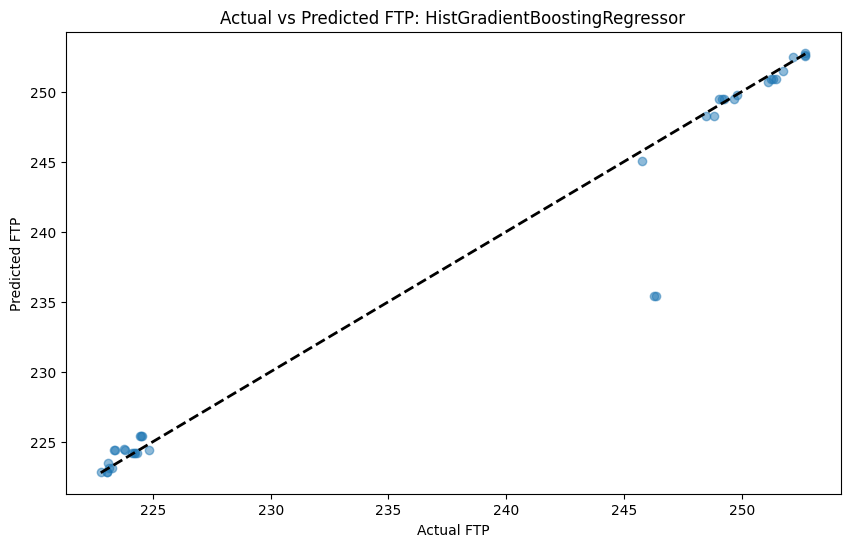

In [60]:
#HistGradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Dropping any rows where FTP is NaN
data = ftp_values.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

X = data[input_cols]  # Features
y = data['FTP']       # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a HistGradientBoostingRegressor model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Predicting on the testing set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Plotting results
plot_results(y_test, y_pred, 'HistGradientBoostingRegressor')

**HistGradientBoostingRegressor model:**

*MSE: 6.65*  
*R²: 0.961*  


Mean Squared Error: 0.011275253977102185
R² Score: 0.9999353030216359


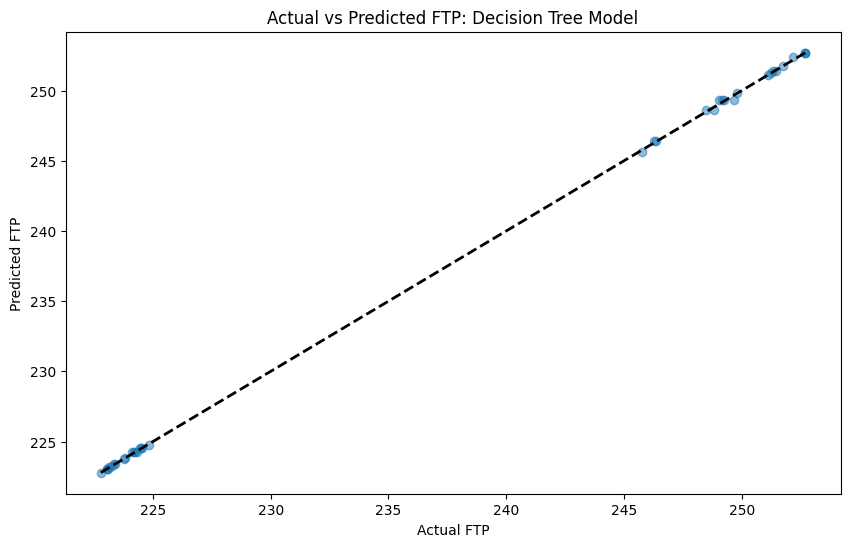

In [61]:
#Decision Tree Model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Random Forest model
from sklearn.model_selection import train_test_split

data = ftp_values

# Dropping any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

X = data[input_cols]  # Features
y = data['FTP']       # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Decision Tree model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Predicting on the testing set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Plotting results
plot_results(y_test, y_pred, 'Decision Tree Model')


**Decision Tree model:**

*MSE: 0.0112*  
*R²: 0.999*  
*Better performance compared to HistGradientBoosterRegressor*

Mean Squared Error: 2.712766717563494
R² Score: 0.98443424777929


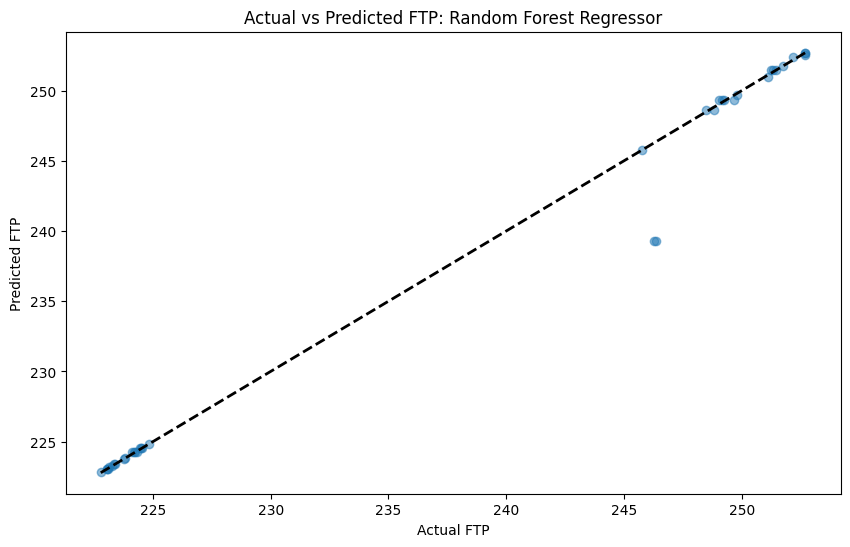

In [62]:
# Random Forest model

from sklearn.ensemble import RandomForestRegressor

data = ftp_values

# Dropping any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

X = data[input_cols]  # Features
y = data['FTP']       # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Creating a Linear Regression model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predicting on the testing set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

plot_results(y_test, y_pred, 'Random Forest Regressor')

**Random Forest model:**

*MSE: 2.71*  
*R²: 0.98*  
*Poorer performance compared to Decision Tree but better compared to HistGradientBoosting Regressor*

**Performance: Decision Tree > Random Forest > HistGradientBoostingRegressor**